   # Predicting the alpha signal using microblogging data

  ## Problem discription
  

    A hedge fund uses 6 financial factors to predict the alpha signal in a stock. This
    alpha signal is used to make purchase decisions about the stock. The hedge fund
    now collected and tagged microblogging data for sentiment from the Social Media
    platform called ‘StockTwits’.
    
    StockTwits is used by people who regularly trade stocks. People on this platform
    tweet about stocks using the special character ‘$’ to indicate the name of the
    stock. These microblogs similar to tweets might contain important information
     about the alpha signal in a stock.

    The hedge fund has anonymised the data, which contains 7 stock factors and an
    alpha signal. This alpha signal is generated using a near perfect algorithmic trading
    strategy. Unfortunately the number of stock factors, collected to run that strategy,
    are extremely high and have to be collected from a large number of data vendors
    at a high price

In [1]:
import os
import pandas as pd
import numpy as np


from sklearn.pipeline import Pipeline
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import json
from sklearn import preprocessing
from sklearn.impute import SimpleImputer

from sklearn import preprocessing
from sklearn.compose import ColumnTransformer

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
import warnings
warnings.filterwarnings('ignore')

### Attribute discription 

Date: The date at which the factors are generated
 
Ticker: The identifier through which the company is listed in the stock
exchange

SF1 - SF7: 7 anonymised Stock Factors that can be used to predict the

Alpha: The alpha signal generated by using a high performing
algorithmic trading strategy. (range: 1 - 4)

Alpha Signals derived from alpha factors are often individually weak, but sufficiently powerful when combined with other factors or data sources, for example, to modulate the signal as a function of the market or economic context.

### Alpha  is a  target attribute which is a multi-class atrribute which has 4 levels

### As stocktwit_tweet and each sentiment score of tweet  are extracted from twitter for further analysis of Alpha for return investment for each company

## Reading the data

In [2]:
data =pd.read_csv("train_factors-1573207730757.csv",sep=',',na_values='unknown',header=0)
test=pd.read_csv("test_factors1.csv",sep=',',na_values='unknown',header=0)
print(data.shape)
print(test.shape)

(27006, 11)
(11575, 10)


In [3]:
data.head(5)

,Id,date,ticker,SF1,SF2,SF3,SF4,SF5,SF6,SF7,alpha
0,1,2018-08-21,$NTAP,-0.628652,0.988891,-0.055714,0.774379,0.551089,-1.329229,-0.995539,2
1,2,2018-10-11,$WYNN,1.315786,1.438754,0.187327,0.608933,-1.153030,1.859441,0.730995,3
2,3,2018-08-21,$DRI,-1.141388,-1.455016,0.332755,0.674502,0.111326,-0.478597,-1.488157,1
3,4,2018-07-10,$ge,-0.054839,-1.454149,-0.162267,-0.681870,0.307869,-0.529987,0.404172,2
4,5,2018-09-12,$FE,-0.686366,0.838865,0.073830,0.679024,0.329463,1.262782,-1.024042,2


In [4]:
data['ticker'] = data['ticker'].str.replace('$','')
data['ticker'] = data['ticker'].str.upper()

data.head()

,Id,date,ticker,SF1,SF2,SF3,SF4,SF5,SF6,SF7,alpha
0,1,2018-08-21,NTAP,-0.628652,0.988891,-0.055714,0.774379,0.551089,-1.329229,-0.995539,2
1,2,2018-10-11,WYNN,1.315786,1.438754,0.187327,0.608933,-1.153030,1.859441,0.730995,3
2,3,2018-08-21,DRI,-1.141388,-1.455016,0.332755,0.674502,0.111326,-0.478597,-1.488157,1
3,4,2018-07-10,GE,-0.054839,-1.454149,-0.162267,-0.681870,0.307869,-0.529987,0.404172,2
4,5,2018-09-12,FE,-0.686366,0.838865,0.073830,0.679024,0.329463,1.262782,-1.024042,2


In [5]:
test['ticker']=test['ticker'].str.replace('$','')
test['ticker']=test['ticker'].str.upper()

In [6]:
test.head()

,Id,date,ticker,SF1,SF2,SF3,SF4,SF5,SF6,SF7
0,270007,2018-07-21,INTC,-3.062194,1.223466,1.741714,2.279266,-1.323573,-0.274912,-4.504449
1,270008,2018-10-05,CTSH,0.816263,-2.184408,0.157975,-0.264743,-0.836282,0.046276,0.826353
2,270009,2018-10-01,CB,0.401281,0.091604,0.083411,-1.147041,-0.485223,-0.601060,1.012811
3,270010,2018-10-24,CTAS,-0.783521,1.192929,0.813831,-0.368166,-1.113656,-0.553581,-0.683803
4,270011,2018-07-27,INTC,0.796507,0.455341,0.679032,0.354336,-1.799055,0.126153,0.297111


In [7]:
print(list(data.columns))

['Id', 'date', 'ticker', 'SF1', 'SF2', 'SF3', 'SF4', 'SF5', 'SF6', 'SF7', 'alpha']


### Json file reading 

In [8]:
import json

In [9]:
with open('train_data-1573118738755.json', 'r') as f:
     sntmnt_json = json.load(f)

In [10]:
sntmnt_json

{'records': [{'stocktwit_tweet': '$AMD going up but hesitating however chart is very stable and going upward',
   'sentiment_score': 3,
   'timestamp': '2018-09-19 18:38:28+00:00',
   'ticker': '$AMD'},
  {'stocktwit_tweet': '@inforlong @MariaGascon Despite\nChina trade war $CAT held very well 👍',
   'sentiment_score': 3,
   'timestamp': '2018-10-09 03:51:06+00:00',
   'ticker': '$CAT'},
  {'stocktwit_tweet': '$AVGO WTF?',
   'sentiment_score': 2,
   'timestamp': '2018-07-12 13:35:32+00:00',
   'ticker': '$AVGO'},
  {'stocktwit_tweet': '$PH\n New Insider Filing On: \n MULLER KLAUS PETER\nTransaction Code: \n http://www.filingscanner.com/Alerts/PH.php',
   'sentiment_score': 2,
   'timestamp': '2018-07-19 03:32:50+00:00',
   'ticker': '$PH'},
  {'stocktwit_tweet': '$FB if it bounces tommorrow do the right thing and GTFO',
   'sentiment_score': 3,
   'timestamp': '2018-08-23 19:07:54+00:00',
   'ticker': '$FB'},
  {'stocktwit_tweet': '$FB as usual......RED  \nevery day.',
   'sentiment_s

In [11]:
train_sntmnt_json = pd.concat([pd.DataFrame(sntmnt_json),pd.DataFrame(list(sntmnt_json['records']))], axis=1).drop('records', 1)

train_sntmnt_json.head()

,sentiment_score,stocktwit_tweet,ticker,timestamp
0,3,$AMD going up but hesitating however chart is ...,$AMD,2018-09-19 18:38:28+00:00
1,3,@inforlong @MariaGascon Despite\nChina trade w...,$CAT,2018-10-09 03:51:06+00:00
2,2,$AVGO WTF?,$AVGO,2018-07-12 13:35:32+00:00
3,2,$PH\n New Insider Filing On: \n MULLER KLAUS P...,$PH,2018-07-19 03:32:50+00:00
4,3,$FB if it bounces tommorrow do the right thing...,$FB,2018-08-23 19:07:54+00:00


In [12]:
train_sntmnt_json['timestamp'] = train_sntmnt_json['timestamp'].str.split(' ').str[0]

In [13]:
train_sntmnt_json['ticker'] = train_sntmnt_json['ticker'].str.replace('$','')
train_sntmnt_json['ticker'] = train_sntmnt_json['ticker'].str.upper()

In [14]:
train_sntmnt_json.head(3)

,sentiment_score,stocktwit_tweet,ticker,timestamp
0,3,$AMD going up but hesitating however chart is ...,AMD,2018-09-19
1,3,@inforlong @MariaGascon Despite\nChina trade w...,CAT,2018-10-09
2,2,$AVGO WTF?,AVGO,2018-07-12


In [15]:
train_sntmnt_json = train_sntmnt_json.groupby(by=['timestamp','ticker'])['sentiment_score'].agg(lambda x: x.value_counts().index[0]).to_frame()

In [16]:
train_sntmnt_json.head()

sentiment_score
timestamp  ticker                 
2018-07-01 AABA                  2
           AAL                   3
           AAP                   1
           AAPL                  2
           ABBV                  0

In [17]:
train_merge = pd.merge(data,train_sntmnt_json,how='left', left_on = ['ticker','date'],right_on=['ticker','timestamp'])

In [18]:
train_merge.head()

,Id,date,ticker,SF1,SF2,SF3,SF4,SF5,SF6,SF7,alpha,sentiment_score
0,1,2018-08-21,NTAP,-0.628652,0.988891,-0.055714,0.774379,0.551089,-1.329229,-0.995539,2,2.0
1,2,2018-10-11,WYNN,1.315786,1.438754,0.187327,0.608933,-1.153030,1.859441,0.730995,3,2.0
2,3,2018-08-21,DRI,-1.141388,-1.455016,0.332755,0.674502,0.111326,-0.478597,-1.488157,1,2.0
3,4,2018-07-10,GE,-0.054839,-1.454149,-0.162267,-0.681870,0.307869,-0.529987,0.404172,2,2.0
4,5,2018-09-12,FE,-0.686366,0.838865,0.073830,0.679024,0.329463,1.262782,-1.024042,2,0.0


In [19]:
train_merge.isnull().sum()

Id                    0
date                  0
ticker                0
SF1                   0
SF2                   0
SF3                   0
SF4                   0
SF5                   0
SF6                   0
SF7                   0
alpha                 0
sentiment_score    2167
dtype: int64

In [20]:
with open('test_data.json', 'r') as f:
     sntmnt_data_test = json.load(f)

In [21]:
test_sntmnt = pd.concat([pd.DataFrame(sntmnt_data_test),pd.DataFrame(list(sntmnt_data_test['records']))], axis=1).drop('records', 1)

In [22]:
test_sntmnt.head(3)

,stocktwit_tweet,ticker,timestamp
0,$CELG nothing to be exited about,$CELG,2018-10-25 14:26:16+00:00
1,$AMD yall exhaust your buyer on first green ca...,$AMD,2018-07-13 13:50:39+00:00
2,$AMD day traders day.,$AMD,2018-09-25 19:10:54+00:00


In [23]:
test_sntmnt['timestamp'] = test_sntmnt['timestamp'].str.split(' ').str[0]

In [24]:
test_sntmnt['ticker'] = test_sntmnt['ticker'].str.replace('$','')
test_sntmnt['ticker'] = test_sntmnt['ticker'].str.upper()

 ## Data Exploring and cleaning

In [30]:
print(data.isnull().sum())

print(test.isnull().sum())

Id        0
date      0
ticker    0
SF1       0
SF2       0
SF3       0
SF4       0
SF5       0
SF6       0
SF7       0
alpha     0
dtype: int64
Id        0
date      0
ticker    0
SF1       0
SF2       0
SF3       0
SF4       0
SF5       0
SF6       0
SF7       0
dtype: int64


## Removing dollar sign from ticker 

In [31]:
data['ticker'] = data['ticker'].str.replace('$', '')
test['ticker'] =test['ticker'].str.replace('$','')

In [32]:
data.head(5)

,Id,date,ticker,SF1,SF2,SF3,SF4,SF5,SF6,SF7,alpha
0,1,2018-08-21,NTAP,-0.628652,0.988891,-0.055714,0.774379,0.551089,-1.329229,-0.995539,2
1,2,2018-10-11,WYNN,1.315786,1.438754,0.187327,0.608933,-1.153030,1.859441,0.730995,3
2,3,2018-08-21,DRI,-1.141388,-1.455016,0.332755,0.674502,0.111326,-0.478597,-1.488157,1
3,4,2018-07-10,GE,-0.054839,-1.454149,-0.162267,-0.681870,0.307869,-0.529987,0.404172,2
4,5,2018-09-12,FE,-0.686366,0.838865,0.073830,0.679024,0.329463,1.262782,-1.024042,2


## Type casting for numerical and categorical 

## For train

In [33]:
for col in['ticker','alpha']:
    data[col]=data[col].astype('category')

In [34]:
for col in['ticker']:
    test[col]=test[col].astype('category')

In [35]:
test.dtypes

Id           int64
date        object
ticker    category
SF1        float64
SF2        float64
SF3        float64
SF4        float64
SF5        float64
SF6        float64
SF7        float64
dtype: object

### for test

Removing Id column because it has more unique

In [36]:
data=data.drop(['Id','date','ticker'], axis=1)
test=test.drop(['Id','date','ticker'],axis=1)

## Numerical and categorical values splitting

## For train

In [37]:
cat_attr = list(data.select_dtypes("category").columns)
num_attr = list(data.columns.difference(cat_attr))

cat_attr.pop()

'alpha'

In [38]:
num_attr

['SF1', 'SF2', 'SF3', 'SF4', 'SF5', 'SF6', 'SF7']

In [39]:
cat_attr

[]

## For test

In [40]:
cat_attr_test=list(test.select_dtypes("category").columns)
num_attr_test=list(test.columns.difference(cat_attr_test))

In [41]:
num_attr_test

['SF1', 'SF2', 'SF3', 'SF4', 'SF5', 'SF6', 'SF7']

## Barchart for alpha

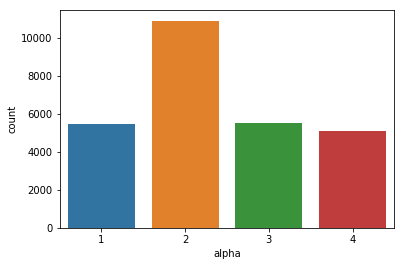

2    10912
3     5536
1     5467
4     5091
Name: alpha, dtype: int64

In [42]:
sns.countplot(x="alpha", data=data)
plt.show()

data.alpha.value_counts()

More companies  invested in alpha 2 stock

 ### A heat map is a graphical representation of data where the individual values contained in a matrix are represented as colors.

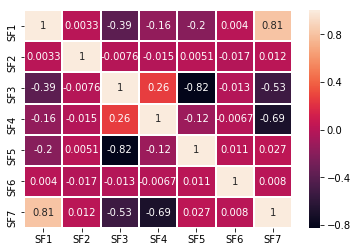

In [43]:
corr = data.corr()
ax = sns.heatmap(corr,annot =True, linewidth = 1, cbar = True)

SF1 and SF2 are multi-correleated

Kdeplot for Stock factors

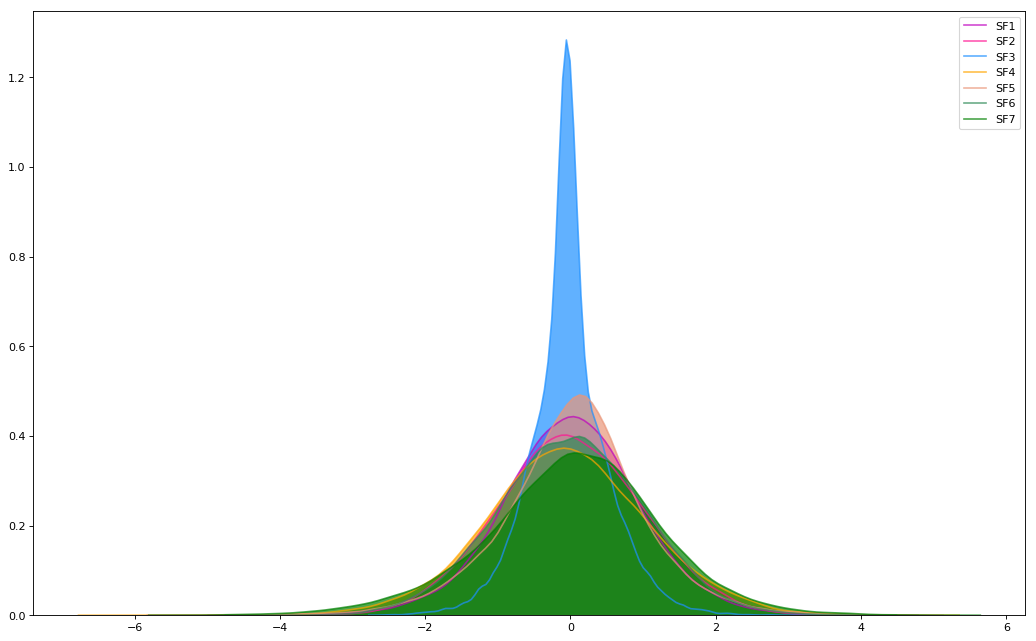

In [44]:
plt.figure(figsize=(16,10), dpi= 80)
sns.kdeplot(data['SF1'], shade=True, color="m", label="SF1", alpha=.7)
sns.kdeplot(data['SF2'], shade=True, color="deeppink", label="SF2", alpha=.7)
sns.kdeplot(data['SF3'], shade=True, color="dodgerblue", label="SF3", alpha=.7)
sns.kdeplot(data['SF4'], shade=True, color="orange", label="SF4", alpha=.7)
sns.kdeplot(data['SF5'], shade=True, color="darksalmon", label="SF5", alpha=.7)
sns.kdeplot(data['SF6'], shade=True, color="seagreen", label="SF6", alpha=.7)
sns.kdeplot(data['SF7'], shade=True, color="g", label="SF7", alpha=.7);

All SMF values are normally distributed

## Train-test split

In [45]:
from sklearn.model_selection import train_test_split

In [46]:
y=data["alpha"]
X=data.drop('alpha', axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20,random_state=123)  

print(X_train.shape,X_test.shape)
print(y_train.shape,y_test.shape)

(21604, 7) (5402, 7)
(21604,) (5402,)


In [47]:
print(X_train.columns)
print(X_test.columns)

Index(['SF1', 'SF2', 'SF3', 'SF4', 'SF5', 'SF6', 'SF7'], dtype='object')
Index(['SF1', 'SF2', 'SF3', 'SF4', 'SF5', 'SF6', 'SF7'], dtype='object')


### Standard scaler for numerical attribute

In [48]:
scaler = StandardScaler()
scaler.fit(X_train[num_attr])

X_train[num_attr]=scaler.transform(X_train[num_attr])
X_test[num_attr]=scaler.transform(X_test[num_attr])

In [49]:
X_train.head()

,SF1,SF2,SF3,SF4,SF5,SF6,SF7
21477,0.747055,0.435764,-0.494819,-2.363322,-0.087905,0.726232,1.875005
16190,0.503281,0.840391,0.174011,-1.065091,-0.567979,-0.863855,0.910406
5698,0.159238,2.871696,-1.138177,-0.924809,1.062687,-0.363051,0.758069
23385,0.740889,-1.719840,0.262537,0.310970,-0.710712,0.984525,0.302660
14472,-1.791616,-0.942727,1.213076,0.118697,-0.208227,0.489027,-1.437917


#### Standard scaler is usefull data which has  negative values

In [50]:
X_train = pd.get_dummies(columns=cat_attr,data=X_train,drop_first=True)
X_test = pd.get_dummies(columns=cat_attr,data=X_test,drop_first=True)

### For test

In [51]:
scaler = StandardScaler()
scaler.fit(test[num_attr])

test[num_attr]=scaler.transform(test[num_attr])

In [52]:
test.head()

,SF1,SF2,SF3,SF4,SF5,SF6,SF7
0,-3.314018,1.222086,3.294968,2.119587,-1.427392,-0.273538,-3.810160
1,0.881272,-2.193096,0.349179,-0.197793,-0.922462,0.046542,0.661347
2,0.432389,0.087797,0.210489,-1.001494,-0.558696,-0.598562,0.817749
3,-0.849199,1.191483,1.569086,-0.292004,-1.209876,-0.551247,-0.605380
4,0.859901,0.452313,1.318356,0.366136,-1.920084,0.126144,0.217416


### Pipeline

In [53]:
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median'))])


categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent', fill_value='missing'))])
    

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_attr),
        ('cat', categorical_transformer, cat_attr)])

## Model building

Decision Tree

In [54]:

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_attr),
        ('cat', categorical_transformer, cat_attr)])

In [55]:
%%time
clf_dt = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', DecisionTreeClassifier())])

dt_param_grid = {'classifier__criterion': ['entropy', 'gini'], 'classifier__max_depth': [6,8,10,12], 
                 "classifier__min_samples_split": [2, 10, 20],"classifier__min_samples_leaf": [1, 5, 10]}

dt_grid = GridSearchCV(clf_dt, param_grid=dt_param_grid, cv=5)

dt_grid.fit(X_train,y_train)

Wall time: 1min 9s


In [56]:
dt_grid.best_params_

{'classifier__criterion': 'entropy',
 'classifier__max_depth': 12,
 'classifier__min_samples_leaf': 10,
 'classifier__min_samples_split': 20}

In [57]:
train_pred = dt_grid.predict(X_train)
test_pred = dt_grid.predict(X_test)

print(dt_grid.score(X_train, y_train))
print(dt_grid.score(X_test, y_test))

0.7434734308461396
0.6653091447611995


In [58]:
print("F1 Score:" , f1_score(y_true= y_test, y_pred = test_pred,average=None))
print(accuracy_score(y_true= y_test, y_pred = test_pred))


F1 Score: [0.52337398 0.83248937 0.49790356 0.55148167]
0.6653091447611995


In [59]:
print("Recall:" , recall_score(y_true= y_test, y_pred = test_pred,average=None))
print("Precison:" , precision_score(y_true= y_test, y_pred = test_pred,average=None))

Recall: [0.49758454 0.9366454  0.42147294 0.5248566 ]
Precison: [0.55198285 0.74917973 0.60819462 0.58095238]


In [60]:
test_sample_pred=dt_grid.predict(test)
test_sample_pred

array([4, 4, 1, ..., 4, 2, 2], dtype=int64)

In [61]:
test=pd.read_csv("test_factors.csv")

In [62]:
new_df = pd.DataFrame(list(zip(test['Id'],test_sample_pred)),columns=['Id','alpha'])

### _Build Random Forest Model - 3_ (Using Stratified KFold)

### Stratified K-Folds cross-validator__

This cross-validation object is a **variation** of KFold that returns stratified folds. The folds are made by **preserving the percentage of samples for each class**.

In [63]:
clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', RandomForestClassifier())])

In [64]:
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=143)

In [65]:
param_grid = {"classifier__n_estimators" : [150, 250, 300],
              "classifier__max_depth" : [15,20,25],
              "classifier__max_features" :[25,30,35],
              "classifier__min_samples_leaf" : [4, 6, 8, 10]}

In [66]:
rf_grid = GridSearchCV(clf, param_grid=dt_param_grid, cv=kfold)

In [67]:
%%time
rf_grid.fit(X_train,y_train)

Wall time: 2min 9s


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=143, shuffle=True),
             error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('preprocessor',
                                        ColumnTransformer(n_jobs=None,
                                                          remainder='drop',
                                                          sparse_threshold=0.3,
                                                          transformer_weights=None,
                                                          transformers=[('num',
                                                                         Pipeline(memory=None,
                                                                                  steps=[('imputer',
                                                                                          SimpleImputer(add_indicator=False,
                                                                

In [68]:
rf_grid.best_params_

train_pred = rf_grid.predict(X_train)
test_pred = rf_grid.predict(X_test)

print(rf_grid.score(X_train, y_train))
print(rf_grid.score(X_test, y_test))

0.7560636919089058
0.6690114772306553


In [69]:
print("F1 Score:" , f1_score(y_true= y_test, y_pred = test_pred,average=None))
print(accuracy_score(y_true= y_test, y_pred = test_pred))


F1 Score: [0.52508361 0.81744186 0.5072314  0.56739812]
0.6690114772306553


In [70]:
print("Recall:" , recall_score(y_true= y_test, y_pred = test_pred,average=None))
print("Precison:" , precision_score(y_true= y_test, y_pred = test_pred,average=None))

Recall: [0.45507246 0.96125798 0.43566992 0.51912046]
Precison: [0.62055336 0.71105866 0.60692213 0.62557604]


In [71]:
test_sample_pred1=rf_grid.predict(test)
test_sample_pred1

array([4, 2, 2, ..., 1, 2, 2], dtype=int64)

In [72]:
new_df1 = pd.DataFrame(list(zip(test['Id'],test_sample_pred1)),columns=['Id','alpha'])
new_df1.shape

(11575, 2)

By tuning parameter in Random forest we get good score

### JSON FILE

In [73]:
### Reading the JSON file

import os
import numpy as np
import nltk
import string

import re, unicodedata
from tqdm import tqdm_notebook as tq
from bs4 import BeautifulSoup

from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

from nltk.corpus import wordnet as wn
from nltk.tokenize.toktok import ToktokTokenizer

import spacy
import en_core_web_sm

from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import LancasterStemmer, WordNetLemmatizer


import warnings
warnings.filterwarnings('ignore')

Using TensorFlow backend.


In [74]:
### Reading the JSON data file

## ==> for Train_json
import json
import pandas as pd
with open('train_data-1573118738755.json', 'r') as f:
    df = json.load(f)

In [75]:
#df

### Converting the data into pandas dataframe

from pandas.io.json import json_normalize
train = pd.concat([pd.DataFrame(df),pd.DataFrame(list(df['records']))],axis=1).drop('records',1)

train.head()

,sentiment_score,stocktwit_tweet,ticker,timestamp
0,3,$AMD going up but hesitating however chart is ...,$AMD,2018-09-19 18:38:28+00:00
1,3,@inforlong @MariaGascon Despite\nChina trade w...,$CAT,2018-10-09 03:51:06+00:00
2,2,$AVGO WTF?,$AVGO,2018-07-12 13:35:32+00:00
3,2,$PH\n New Insider Filing On: \n MULLER KLAUS P...,$PH,2018-07-19 03:32:50+00:00
4,3,$FB if it bounces tommorrow do the right thing...,$FB,2018-08-23 19:07:54+00:00


In [76]:
## ==> for Test_json
import json
import pandas as pd
with open('test_data.json', 'r') as f:
    df_test = json.load(f)

In [77]:
#df_test

test_json = pd.concat([pd.DataFrame(df_test),pd.DataFrame(list(df_test['records']))],axis=1).drop('records',1)

test_json.head()

,stocktwit_tweet,ticker,timestamp
0,$CELG nothing to be exited about,$CELG,2018-10-25 14:26:16+00:00
1,$AMD yall exhaust your buyer on first green ca...,$AMD,2018-07-13 13:50:39+00:00
2,$AMD day traders day.,$AMD,2018-09-25 19:10:54+00:00
3,$CBS https://tenor.com/wLB8.gif,$CBS,2018-07-27 22:45:48+00:00
4,$MU weak price action so far today. Don’t be a...,$MU,2018-07-31 14:59:06+00:00


### Shape of the JSON file

In [78]:
## ==> for train_json
train.shape

(1039131, 4)

In [79]:
## for Test_json
test_json.shape

(265022, 3)

In [80]:
## ==> for train_json
train.dtypes

sentiment_score     int64
stocktwit_tweet    object
ticker             object
timestamp          object
dtype: object

## for Test_json

In [81]:
test_json.dtypes

stocktwit_tweet    object
ticker             object
timestamp          object
dtype: object

In [82]:
 ### reshape the " ticker " Column in json file

## ==> for Train_json
train['ticker']=train['ticker'].str.replace('$','')
train['ticker']=train['ticker'].str.upper()

In [83]:
train.head()

,sentiment_score,stocktwit_tweet,ticker,timestamp
0,3,$AMD going up but hesitating however chart is ...,AMD,2018-09-19 18:38:28+00:00
1,3,@inforlong @MariaGascon Despite\nChina trade w...,CAT,2018-10-09 03:51:06+00:00
2,2,$AVGO WTF?,AVGO,2018-07-12 13:35:32+00:00
3,2,$PH\n New Insider Filing On: \n MULLER KLAUS P...,PH,2018-07-19 03:32:50+00:00
4,3,$FB if it bounces tommorrow do the right thing...,FB,2018-08-23 19:07:54+00:00


In [84]:
## ==> for Test_json
test_json['ticker'] = test_json['ticker'].str.replace('$','')
test_json['ticker'] = test_json['ticker'].str.upper()

In [85]:
test_json.head()

,stocktwit_tweet,ticker,timestamp
0,$CELG nothing to be exited about,CELG,2018-10-25 14:26:16+00:00
1,$AMD yall exhaust your buyer on first green ca...,AMD,2018-07-13 13:50:39+00:00
2,$AMD day traders day.,AMD,2018-09-25 19:10:54+00:00
3,$CBS https://tenor.com/wLB8.gif,CBS,2018-07-27 22:45:48+00:00
4,$MU weak price action so far today. Don’t be a...,MU,2018-07-31 14:59:06+00:00


### Checking the Tweets with respect to Score

In [86]:
train[train['sentiment_score']==0].head()

,sentiment_score,stocktwit_tweet,ticker,timestamp
5,0,$FB as usual......RED \nevery day.,FB,2018-08-02 11:40:49+00:00
17,0,"$mu mms took out the SLs, yet it still won&#39...",MU,2018-09-05 14:23:16+00:00
25,0,$MSFT short the high. easy flip,MSFT,2018-07-12 18:13:49+00:00
31,0,$NFLX Astonishing crash for NFLX by late next ...,NFLX,2018-10-07 02:53:29+00:00
37,0,$MU It is the best time to leave within 15 min...,MU,2018-07-04 20:35:58+00:00


In [87]:
train[train['sentiment_score']==1].head()

,sentiment_score,stocktwit_tweet,ticker,timestamp
20,1,$MU you all know that when it drops in one day...,MU,2018-09-06 19:32:52+00:00
24,1,$NFLX Looks like this resistance will be broke...,NFLX,2018-09-26 16:34:10+00:00
29,1,$GE going red today,GE,2018-07-20 11:14:35+00:00
33,1,"$FB For my stupid fb bull friends, hehehe, \...",FB,2018-07-26 13:19:12+00:00
39,1,$AMD analysts on Estimize expect 7.61% YoY gro...,AMD,2018-09-06 12:36:09+00:00


In [88]:
train[train['sentiment_score']==2].head()

,sentiment_score,stocktwit_tweet,ticker,timestamp
2,2,$AVGO WTF?,AVGO,2018-07-12 13:35:32+00:00
3,2,$PH\n New Insider Filing On: \n MULLER KLAUS P...,PH,2018-07-19 03:32:50+00:00
6,2,$AET UnitedHealth Group Goes Ex-Dividend Today...,AET,2018-09-07 15:01:06+00:00
8,2,@InCyD3R @Ferrabi I bet you’re also the one sa...,AMZN,2018-10-28 01:19:27+00:00
9,2,$AMD Pastor the Stooge,AMD,2018-08-17 13:35:00+00:00


In [89]:
train[train['sentiment_score']==3].head()

,sentiment_score,stocktwit_tweet,ticker,timestamp
0,3,$AMD going up but hesitating however chart is ...,AMD,2018-09-19 18:38:28+00:00
1,3,@inforlong @MariaGascon Despite\nChina trade w...,CAT,2018-10-09 03:51:06+00:00
4,3,$FB if it bounces tommorrow do the right thing...,FB,2018-08-23 19:07:54+00:00
19,3,$MU 5 min chart you can see Where the long ter...,MU,2018-08-09 14:09:52+00:00
36,3,$AMD Good luck to everyone that holds.,AMD,2018-10-24 19:52:13+00:00


In [90]:
train[train['sentiment_score']==4].head()

,sentiment_score,stocktwit_tweet,ticker,timestamp
7,4,$NOC let&#39;s see when we can hit 310,NOC,2018-09-12 20:48:40+00:00
16,4,$AMD buying more,AMD,2018-09-18 15:45:22+00:00
22,4,$MU doesn’t miss MU Long Rally (Bullish),MU,2018-07-24 08:53:28+00:00
26,4,"$AMZN $3000 Target,",AMZN,2018-09-04 14:12:54+00:00
42,4,#Update(4) $COST Jul-27 220 Calls Up +25%. 1...,COST,2018-07-24 13:50:53+00:00


### Changing the timestamp column as month & day

In [91]:
## ==> for Train_json
train['timestamp'] = train['timestamp'].str.split(' ').str[0]
train.head(4)

,sentiment_score,stocktwit_tweet,ticker,timestamp
0,3,$AMD going up but hesitating however chart is ...,AMD,2018-09-19
1,3,@inforlong @MariaGascon Despite\nChina trade w...,CAT,2018-10-09
2,2,$AVGO WTF?,AVGO,2018-07-12
3,2,$PH\n New Insider Filing On: \n MULLER KLAUS P...,PH,2018-07-19


In [92]:
train['month'] = train['timestamp'].str.split('-', expand = True)[1]
train['day'] = train['timestamp'].str.split('-',expand = True)[2]

train.head(3)

,sentiment_score,stocktwit_tweet,ticker,timestamp,month,day
0,3,$AMD going up but hesitating however chart is ...,AMD,2018-09-19,09,19
1,3,@inforlong @MariaGascon Despite\nChina trade w...,CAT,2018-10-09,10,09
2,2,$AVGO WTF?,AVGO,2018-07-12,07,12


In [93]:
train.dtypes

## ==> for Test_json
test_json['timestamp'] = test_json['timestamp'].str.split(' ').str[0]
test_json.head(4)

,stocktwit_tweet,ticker,timestamp
0,$CELG nothing to be exited about,CELG,2018-10-25
1,$AMD yall exhaust your buyer on first green ca...,AMD,2018-07-13
2,$AMD day traders day.,AMD,2018-09-25
3,$CBS https://tenor.com/wLB8.gif,CBS,2018-07-27


In [94]:
test_json['month'] = test_json['timestamp'].str.split('-', expand = True)[1]
test_json['day'] = test_json['timestamp'].str.split('-',expand = True)[2]

In [95]:
test_json.head()

,stocktwit_tweet,ticker,timestamp,month,day
0,$CELG nothing to be exited about,CELG,2018-10-25,10,25
1,$AMD yall exhaust your buyer on first green ca...,AMD,2018-07-13,07,13
2,$AMD day traders day.,AMD,2018-09-25,09,25
3,$CBS https://tenor.com/wLB8.gif,CBS,2018-07-27,07,27
4,$MU weak price action so far today. Don’t be a...,MU,2018-07-31,07,31


In [96]:
test_json.dtypes

stocktwit_tweet    object
ticker             object
timestamp          object
month              object
day                object
dtype: object

2    464402
3    208031
4    153905
1    120771
0     92022
Name: sentiment_score, dtype: int64

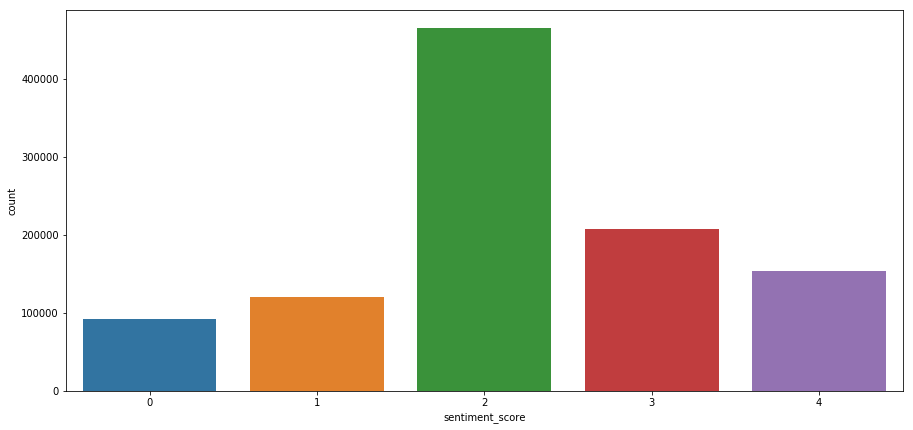

In [97]:
f, ax = plt.subplots(figsize=(15,7))
sns.countplot('sentiment_score',data=train);

train.sentiment_score.value_counts()

Sentiment score 2 has more number of tweets

### Type casting in JSON file

In [98]:
## ==> for Train_json
for i in ['stocktwit_tweet','sentiment_score','ticker','month','day']:
    train[i] = train[i].astype('category')

train.dtypes

sentiment_score    category
stocktwit_tweet    category
ticker             category
timestamp            object
month              category
day                category
dtype: object

In [99]:
## ==> for Test_json
for i in ['stocktwit_tweet','ticker','month','day']:
  test_json[i] = test_json[i].astype('category')

test_json.dtypes

stocktwit_tweet    category
ticker             category
timestamp            object
month              category
day                category
dtype: object

In [100]:
### Removing the Unnecessary columns in JSON file

## ==> for train_json
train.drop('timestamp', axis=1,inplace=True)
train.head()

train.dtypes

sentiment_score    category
stocktwit_tweet    category
ticker             category
month              category
day                category
dtype: object

In [101]:
## ==> for test_json
test_json.drop('timestamp', axis=1,inplace=True)
test_json.head()

test_json.dtypes

stocktwit_tweet    category
ticker             category
month              category
day                category
dtype: object

### Describing the Data in JSON file

In [102]:
## ==> for Train_json
train.describe()

,sentiment_score,stocktwit_tweet,ticker,month,day
count,1039131,1039131,1039131,1039131,1039131
unique,5,959608,1530,4,31
top,2,$AMD,AMD,10,25
freq,464402,2474,165784,274333,52135


In [103]:
## ==> for Test_json
test_json.describe()

,stocktwit_tweet,ticker,month,day
count,265022,265022,265022,265022
unique,252890,968,4,31
top,$AMD,AMD,10,25
freq,622,42677,69935,13358


In [104]:
## Cleaning the Tweets data

CONTRACTION_MAP = {
"ain't": "is not",
"aren't": "are not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he would",
"he'd've": "he would have",
"he'll": "he will",
"he'll've": "he he will have",
"he's": "he is",
"how'd": "how did",
"how'd'y": "how do you",
"how'll": "how will",
"how's": "how is",
"I'd": "I would",
"I'd've": "I would have",
"I'll": "I will",
"I'll've": "I will have",
"I'm": "I am",
"I've": "I have",
"i'd": "i would",
"i'd've": "i would have",
"i'll": "i will",
"i'll've": "i will have",
"i'm": "i am",
"i've": "i have",
"isn't": "is not",
"it'd": "it would",
"it'd've": "it would have",
"it'll": "it will",
"it'll've": "it will have",
"it's": "it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"mightn't've": "might not have",
"must've": "must have",
"mustn't": "must not",
"mustn't've": "must not have",
"needn't": "need not",
"needn't've": "need not have",
"o'clock": "of the clock",
"oughtn't": "ought not",
"oughtn't've": "ought not have",
"shan't": "shall not",
"sha'n't": "shall not",
"shan't've": "shall not have",
"she'd": "she would",
"she'd've": "she would have",
"she'll": "she will",
"she'll've": "she will have",
"she's": "she is",
"should've": "should have",
"shouldn't": "should not",
"shouldn't've": "should not have",
"so've": "so have",
"so's": "so as",
"that'd": "that would",
"that'd've": "that would have",
"that's": "that is",
"there'd": "there would",
"there'd've": "there would have",
"there's": "there is",
"they'd": "they would",
"they'd've": "they would have",
"they'll": "they will",
"they'll've": "they will have",
"they're": "they are",
"they've": "they have",
"to've": "to have",
"wasn't": "was not",
"we'd": "we would",
"we'd've": "we would have",
"we'll": "we will",
"we'll've": "we will have",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what will",
"what'll've": "what will have",
"what're": "what are",
"what's": "what is",
"what've": "what have",
"when's": "when is",
"when've": "when have",
"where'd": "where did",
"where's": "where is",
"where've": "where have",
"who'll": "who will",
"who'll've": "who will have",
"who's": "who is",
"who've": "who have",
"why's": "why is",
"why've": "why have",
"will've": "will have",
"won't": "will not",
"won't've": "will not have",
"would've": "would have",
"wouldn't": "would not",
"wouldn't've": "would not have",
"y'all": "you all",
"y'all'd": "you all would",
"y'all'd've": "you all would have",
"y'all're": "you all are",
"y'all've": "you all have",
"you'd": "you would",
"you'd've": "you would have",
"you'll": "you will",
"you'll've": "you will have",
"you're": "you are",
"you've": "you have"
}

In [105]:
import nltk
nltk.download('stopwords')

tokenizer = ToktokTokenizer()
stopword_list = nltk.corpus.stopwords.words('english')
stopword_list.remove('no')
stopword_list.remove('not')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\himas\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Converting the emoji's to words

In [106]:
# !pip install emoji

In [107]:
import emoji
## ==> for Train_json
train['Cleaned_data'] = train['stocktwit_tweet'].apply(lambda x: emoji.demojize(x))

  ##  for Test_json

In [108]:
test_json['Cleaned_data'] = test_json['stocktwit_tweet'].apply(lambda x: emoji.demojize(x))

In [109]:
## ==> for Train_json
train['Cleaned_data'] = train['Cleaned_data'].str.replace(":", "",regex=False)
train['Cleaned_data'] = train['Cleaned_data'].str.replace("_", " ",regex=False)

train.head()

,sentiment_score,stocktwit_tweet,ticker,month,day,Cleaned_data
0,3,$AMD going up but hesitating however chart is ...,AMD,09,19,$AMD going up but hesitating however chart is ...
1,3,@inforlong @MariaGascon Despite\nChina trade w...,CAT,10,09,@inforlong @MariaGascon Despite\nChina trade w...
2,2,$AVGO WTF?,AVGO,07,12,$AVGO WTF?
3,2,$PH\n New Insider Filing On: \n MULLER KLAUS P...,PH,07,19,$PH\n New Insider Filing On \n MULLER KLAUS PE...
4,3,$FB if it bounces tommorrow do the right thing...,FB,08,23,$FB if it bounces tommorrow do the right thing...


In [110]:
## ==> for Test_json
test_json['Cleaned_data'] = test_json['Cleaned_data'].str.replace(":", "",regex=False)
test_json['Cleaned_data'] = test_json['Cleaned_data'].str.replace("_", " ",regex=False)

test_json.head()

,stocktwit_tweet,ticker,month,day,Cleaned_data
0,$CELG nothing to be exited about,CELG,10,25,$CELG nothing to be exited about
1,$AMD yall exhaust your buyer on first green ca...,AMD,07,13,$AMD yall exhaust your buyer on first green ca...
2,$AMD day traders day.,AMD,09,25,$AMD day traders day.
3,$CBS https://tenor.com/wLB8.gif,CBS,07,27,$CBS https//tenor.com/wLB8.gif
4,$MU weak price action so far today. Don’t be a...,MU,07,31,$MU weak price action so far today. Don’t be a...


### Removing "http" & "WWW" links

In [111]:
## ==>for Train_json
train['Cleaned_data'] = train['Cleaned_data'].str.replace('http\S*|www.\S*','', case=False)
train.head()

,sentiment_score,stocktwit_tweet,ticker,month,day,Cleaned_data
0,3,$AMD going up but hesitating however chart is ...,AMD,09,19,$AMD going up but hesitating however chart is ...
1,3,@inforlong @MariaGascon Despite\nChina trade w...,CAT,10,09,@inforlong @MariaGascon Despite\nChina trade w...
2,2,$AVGO WTF?,AVGO,07,12,$AVGO WTF?
3,2,$PH\n New Insider Filing On: \n MULLER KLAUS P...,PH,07,19,$PH\n New Insider Filing On \n MULLER KLAUS PE...
4,3,$FB if it bounces tommorrow do the right thing...,FB,08,23,$FB if it bounces tommorrow do the right thing...


In [112]:
## ==> for Test_json
test_json['Cleaned_data'] = test_json['Cleaned_data'].str.replace('http\S*|www.\S*','', case=False)
test_json.head()

,stocktwit_tweet,ticker,month,day,Cleaned_data
0,$CELG nothing to be exited about,CELG,10,25,$CELG nothing to be exited about
1,$AMD yall exhaust your buyer on first green ca...,AMD,07,13,$AMD yall exhaust your buyer on first green ca...
2,$AMD day traders day.,AMD,09,25,$AMD day traders day.
3,$CBS https://tenor.com/wLB8.gif,CBS,07,27,$CBS
4,$MU weak price action so far today. Don’t be a...,MU,07,31,$MU weak price action so far today. Don’t be a...


### Removing "@" from tweets

In [113]:
## ==> for Train_json
train['Cleaned_data'] = train['Cleaned_data'].str.replace("@[\w]*","")

train.head()

,sentiment_score,stocktwit_tweet,ticker,month,day,Cleaned_data
0,3,$AMD going up but hesitating however chart is ...,AMD,09,19,$AMD going up but hesitating however chart is ...
1,3,@inforlong @MariaGascon Despite\nChina trade w...,CAT,10,09,Despite\nChina trade war $CAT held very well...
2,2,$AVGO WTF?,AVGO,07,12,$AVGO WTF?
3,2,$PH\n New Insider Filing On: \n MULLER KLAUS P...,PH,07,19,$PH\n New Insider Filing On \n MULLER KLAUS PE...
4,3,$FB if it bounces tommorrow do the right thing...,FB,08,23,$FB if it bounces tommorrow do the right thing...


In [114]:
## for Test_json
test_json['Cleaned_data'] = test_json['Cleaned_data'].str.replace("@[\w]*","")

test_json.head()

,stocktwit_tweet,ticker,month,day,Cleaned_data
0,$CELG nothing to be exited about,CELG,10,25,$CELG nothing to be exited about
1,$AMD yall exhaust your buyer on first green ca...,AMD,07,13,$AMD yall exhaust your buyer on first green ca...
2,$AMD day traders day.,AMD,09,25,$AMD day traders day.
3,$CBS https://tenor.com/wLB8.gif,CBS,07,27,$CBS
4,$MU weak price action so far today. Don’t be a...,MU,07,31,$MU weak price action so far today. Don’t be a...


In [115]:
### Removing Accented Chars from Tweet

def remove_accented_chars(text):
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    return text

In [116]:
## ==> for Train_json
train['Cleaned_data'] = train['Cleaned_data'].apply(remove_accented_chars)
train.head()

,sentiment_score,stocktwit_tweet,ticker,month,day,Cleaned_data
0,3,$AMD going up but hesitating however chart is ...,AMD,09,19,$AMD going up but hesitating however chart is ...
1,3,@inforlong @MariaGascon Despite\nChina trade w...,CAT,10,09,Despite\nChina trade war $CAT held very well...
2,2,$AVGO WTF?,AVGO,07,12,$AVGO WTF?
3,2,$PH\n New Insider Filing On: \n MULLER KLAUS P...,PH,07,19,$PH\n New Insider Filing On \n MULLER KLAUS PE...
4,3,$FB if it bounces tommorrow do the right thing...,FB,08,23,$FB if it bounces tommorrow do the right thing...


In [117]:
## ==> for Test_json
test_json['Cleaned_data'] = test_json['Cleaned_data'].apply(remove_accented_chars)
test_json.head()

,stocktwit_tweet,ticker,month,day,Cleaned_data
0,$CELG nothing to be exited about,CELG,10,25,$CELG nothing to be exited about
1,$AMD yall exhaust your buyer on first green ca...,AMD,07,13,$AMD yall exhaust your buyer on first green ca...
2,$AMD day traders day.,AMD,09,25,$AMD day traders day.
3,$CBS https://tenor.com/wLB8.gif,CBS,07,27,$CBS
4,$MU weak price action so far today. Don’t be a...,MU,07,31,$MU weak price action so far today. Dont be af...


### converting the text to lower case

In [118]:
## ==>for Train_json
train['Cleaned_data']=train['Cleaned_data'].str.lower()
train.head()

,sentiment_score,stocktwit_tweet,ticker,month,day,Cleaned_data
0,3,$AMD going up but hesitating however chart is ...,AMD,09,19,$amd going up but hesitating however chart is ...
1,3,@inforlong @MariaGascon Despite\nChina trade w...,CAT,10,09,despite\nchina trade war $cat held very well...
2,2,$AVGO WTF?,AVGO,07,12,$avgo wtf?
3,2,$PH\n New Insider Filing On: \n MULLER KLAUS P...,PH,07,19,$ph\n new insider filing on \n muller klaus pe...
4,3,$FB if it bounces tommorrow do the right thing...,FB,08,23,$fb if it bounces tommorrow do the right thing...


In [119]:
## ==> for Test_json
test_json['Cleaned_data']=test_json['Cleaned_data'].str.lower()
test_json.head()

,stocktwit_tweet,ticker,month,day,Cleaned_data
0,$CELG nothing to be exited about,CELG,10,25,$celg nothing to be exited about
1,$AMD yall exhaust your buyer on first green ca...,AMD,07,13,$amd yall exhaust your buyer on first green ca...
2,$AMD day traders day.,AMD,09,25,$amd day traders day.
3,$CBS https://tenor.com/wLB8.gif,CBS,07,27,$cbs
4,$MU weak price action so far today. Don’t be a...,MU,07,31,$mu weak price action so far today. dont be af...


### Removing the empty space in tweets

In [120]:
## ==> for Train_json
emptytweets1 = train[['stocktwit_tweet','ticker']].apply(lambda row: (len(row['stocktwit_tweet'])-len(row['ticker']) ==0), axis=1)

emptytweets = train[emptytweets1]

emptytweets.head()

,sentiment_score,stocktwit_tweet,ticker,month,day,Cleaned_data


In [121]:
train = train[-emptytweets1]

In [122]:
train['Cleaned_data'][1:15]

1       despite\nchina trade war $cat held very well...
2                                            $avgo wtf?
3     $ph\n new insider filing on \n muller klaus pe...
4     $fb if it bounces tommorrow do the right thing...
5                   $fb as usual......red  \nevery day.
6     $aet unitedhealth group goes ex-dividend today...
7                $noc let&#39;s see when we can hit 310
8       i bet youre also the one saying $amzn should...
9                                $amd pastor the stooge
10    $nflx called it friday hahahaha suckers sold f...
11    $gww exp7/20/2018|maxpain292.5|highputoi250.0(...
12    $nflx day in, day out this puppy is making peo...
13                                                $aapl
14                                                $antm
Name: Cleaned_data, dtype: object

In [123]:
## ==> for Test_json
emptytweets2 = test_json[['stocktwit_tweet','ticker']].apply(lambda row: (len(row['stocktwit_tweet'])-len(row['ticker']) ==0), axis=1)

test_emptytweets = test_json[emptytweets2]

In [124]:
test_emptytweets.head()

test_json = test_json[-emptytweets2]

In [125]:
test_json['Cleaned_data'][1:15]

train.describe()

,sentiment_score,stocktwit_tweet,ticker,month,day,Cleaned_data
count,1039131,1039131,1039131,1039131,1039131,1039131
unique,5,959608,1530,4,31,943703
top,2,$AMD,AMD,10,25,$amd
freq,464402,2474,165784,274333,52135,2496


### Removing "dollarsign" from Tweet

In [126]:
## ==> for Train_json
train['Cleaned_data']=train['Cleaned_data'].str.replace(r'\$\W+',"")
train.head()

,sentiment_score,stocktwit_tweet,ticker,month,day,Cleaned_data
0,3,$AMD going up but hesitating however chart is ...,AMD,09,19,$amd going up but hesitating however chart is ...
1,3,@inforlong @MariaGascon Despite\nChina trade w...,CAT,10,09,despite\nchina trade war $cat held very well...
2,2,$AVGO WTF?,AVGO,07,12,$avgo wtf?
3,2,$PH\n New Insider Filing On: \n MULLER KLAUS P...,PH,07,19,$ph\n new insider filing on \n muller klaus pe...
4,3,$FB if it bounces tommorrow do the right thing...,FB,08,23,$fb if it bounces tommorrow do the right thing...


In [127]:
## ==> for Test_json
test_json['Cleaned_data']=test_json['Cleaned_data'].str.replace(r'\$\W+',"")
test_json.head()

,stocktwit_tweet,ticker,month,day,Cleaned_data
0,$CELG nothing to be exited about,CELG,10,25,$celg nothing to be exited about
1,$AMD yall exhaust your buyer on first green ca...,AMD,07,13,$amd yall exhaust your buyer on first green ca...
2,$AMD day traders day.,AMD,09,25,$amd day traders day.
3,$CBS https://tenor.com/wLB8.gif,CBS,07,27,$cbs
4,$MU weak price action so far today. Don’t be a...,MU,07,31,$mu weak price action so far today. dont be af...


### Removing Repeating Words in Tweet

In [128]:
## ==> for Train_json
train['Cleaned_data'] = train['Cleaned_data'].apply(lambda x : re.sub(r'(.)\1{1,}', r'\1\1', x) )
train.head()

,sentiment_score,stocktwit_tweet,ticker,month,day,Cleaned_data
0,3,$AMD going up but hesitating however chart is ...,AMD,09,19,$amd going up but hesitating however chart is ...
1,3,@inforlong @MariaGascon Despite\nChina trade w...,CAT,10,09,despite\nchina trade war $cat held very well...
2,2,$AVGO WTF?,AVGO,07,12,$avgo wtf?
3,2,$PH\n New Insider Filing On: \n MULLER KLAUS P...,PH,07,19,$ph\n new insider filing on \n muller klaus pe...
4,3,$FB if it bounces tommorrow do the right thing...,FB,08,23,$fb if it bounces tommorrow do the right thing...


In [129]:
## ==> for Test_json
test_json['Cleaned_data'] = test_json['Cleaned_data'].apply(lambda x : re.sub(r'(.)\1{1,}', r'\1\1', x) )
test_json.head()

,stocktwit_tweet,ticker,month,day,Cleaned_data
0,$CELG nothing to be exited about,CELG,10,25,$celg nothing to be exited about
1,$AMD yall exhaust your buyer on first green ca...,AMD,07,13,$amd yall exhaust your buyer on first green ca...
2,$AMD day traders day.,AMD,09,25,$amd day traders day.
3,$CBS https://tenor.com/wLB8.gif,CBS,07,27,$cbs
4,$MU weak price action so far today. Don’t be a...,MU,07,31,$mu weak price action so far today. dont be af...


### Removing Special Characters,Punctuations, Numbers and Unnecessary Hashtags in tweets

In [130]:
## ==> for train_json
train['Cleaned_data'] = train['Cleaned_data'].str.replace("[^a-zA-Z]", " ")
train['Cleaned_data'] = train['Cleaned_data'].str.replace("[#+]?\B", "")
train.head()

,sentiment_score,stocktwit_tweet,ticker,month,day,Cleaned_data
0,3,$AMD going up but hesitating however chart is ...,AMD,09,19,amd going up but hesitating however chart is ...
1,3,@inforlong @MariaGascon Despite\nChina trade w...,CAT,10,09,despite china trade war cat held very well ...
2,2,$AVGO WTF?,AVGO,07,12,avgo wtf
3,2,$PH\n New Insider Filing On: \n MULLER KLAUS P...,PH,07,19,ph new insider filing on muller klaus pete...
4,3,$FB if it bounces tommorrow do the right thing...,FB,08,23,fb if it bounces tommorrow do the right thing...


In [131]:
## ==> for Test_json
test_json['Cleaned_data'] = test_json['Cleaned_data'].str.replace("[^a-zA-Z]", " ")
test_json['Cleaned_data'] = test_json['Cleaned_data'].str.replace("[#+]?\B", "")
test_json.head()

,stocktwit_tweet,ticker,month,day,Cleaned_data
0,$CELG nothing to be exited about,CELG,10,25,celg nothing to be exited about
1,$AMD yall exhaust your buyer on first green ca...,AMD,07,13,amd yall exhaust your buyer on first green ca...
2,$AMD day traders day.,AMD,09,25,amd day traders day
3,$CBS https://tenor.com/wLB8.gif,CBS,07,27,cbs
4,$MU weak price action so far today. Don’t be a...,MU,07,31,mu weak price action so far today dont be af...


### Expanding Contractions

In [132]:
def expand_contractions(text, contraction_mapping=CONTRACTION_MAP):
    
    contractions_pattern = re.compile('({})'.format('|'.join(contraction_mapping.keys())), 
                                      flags=re.IGNORECASE|re.DOTALL)
    def expand_match(contraction):
        match = contraction.group(0)
        first_char = match[0]
        expanded_contraction = contraction_mapping.get(match)\
                                if contraction_mapping.get(match)\
                                else contraction_mapping.get(match.lower())                       
        expanded_contraction = first_char+expanded_contraction[1:]
        return expanded_contraction
        
    expanded_text = contractions_pattern.sub(expand_match, text)
    expanded_text = re.sub("'", "", expanded_text)
    return expanded_text

In [133]:
## ==> Train_json
train['Cleaned_data'] = train['Cleaned_data'].apply(expand_contractions)
train.head()

,sentiment_score,stocktwit_tweet,ticker,month,day,Cleaned_data
0,3,$AMD going up but hesitating however chart is ...,AMD,09,19,amd going up but hesitating however chart is ...
1,3,@inforlong @MariaGascon Despite\nChina trade w...,CAT,10,09,despite china trade war cat held very well ...
2,2,$AVGO WTF?,AVGO,07,12,avgo wtf
3,2,$PH\n New Insider Filing On: \n MULLER KLAUS P...,PH,07,19,ph new insider filing on muller klaus pete...
4,3,$FB if it bounces tommorrow do the right thing...,FB,08,23,fb if it bounces tommorrow do the right thing...


In [134]:
## ==> for Test_json
test_json['Cleaned_data'] = test_json['Cleaned_data'].apply(expand_contractions)
test_json.head()

,stocktwit_tweet,ticker,month,day,Cleaned_data
0,$CELG nothing to be exited about,CELG,10,25,celg nothing to be exited about
1,$AMD yall exhaust your buyer on first green ca...,AMD,07,13,amd yall exhaust your buyer on first green ca...
2,$AMD day traders day.,AMD,09,25,amd day traders day
3,$CBS https://tenor.com/wLB8.gif,CBS,07,27,cbs
4,$MU weak price action so far today. Don’t be a...,MU,07,31,mu weak price action so far today dont be af...


In [135]:
### Removing the Stopwords in tweets

def remove_stopwords(text, is_lower_case=False):
    tokens = tokenizer.tokenize(text)
    tokens = [token.strip() for token in tokens]
    filtered_tokens = [token for token in tokens if token not in stopword_list]
    filtered_text = ' '.join(filtered_tokens)    
    return filtered_text

In [136]:
## ==> for train_json
train['Cleaned_data'] = train['Cleaned_data'].apply(remove_stopwords)
train.head()

,sentiment_score,stocktwit_tweet,ticker,month,day,Cleaned_data
0,3,$AMD going up but hesitating however chart is ...,AMD,09,19,amd going hesitating however chart stable goin...
1,3,@inforlong @MariaGascon Despite\nChina trade w...,CAT,10,09,despite china trade war cat held well thumbs
2,2,$AVGO WTF?,AVGO,07,12,avgo wtf
3,2,$PH\n New Insider Filing On: \n MULLER KLAUS P...,PH,07,19,ph new insider filing muller klaus peter trans...
4,3,$FB if it bounces tommorrow do the right thing...,FB,08,23,fb bounces tommorrow right thing gtfo


In [137]:
## ==> for Test_json
test_json['Cleaned_data'] = test_json['Cleaned_data'].apply(remove_stopwords)
test_json.head()

,stocktwit_tweet,ticker,month,day,Cleaned_data
0,$CELG nothing to be exited about,CELG,10,25,celg nothing exited
1,$AMD yall exhaust your buyer on first green ca...,AMD,07,13,amd yall exhaust buyer first green candle byee
2,$AMD day traders day.,AMD,09,25,amd day traders day
3,$CBS https://tenor.com/wLB8.gif,CBS,07,27,cbs
4,$MU weak price action so far today. Don’t be a...,MU,07,31,mu weak price action far today dont afraid go ...


In [138]:
import nltk

nltk.download('punkt')

import nltk
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\himas\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\himas\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

### Tokenizing the Cleaned_data

In [139]:
## ==> for Train_json
token_text = []

for i in train['Cleaned_data']:
    token_text.append(word_tokenize(i))
    
train['Processed_data'] = token_text

train.head()

,sentiment_score,stocktwit_tweet,ticker,month,day,Cleaned_data,Processed_data
0,3,$AMD going up but hesitating however chart is ...,AMD,09,19,amd going hesitating however chart stable goin...,"[amd, going, hesitating, however, chart, stabl..."
1,3,@inforlong @MariaGascon Despite\nChina trade w...,CAT,10,09,despite china trade war cat held well thumbs,"[despite, china, trade, war, cat, held, well, ..."
2,2,$AVGO WTF?,AVGO,07,12,avgo wtf,"[avgo, wtf]"
3,2,$PH\n New Insider Filing On: \n MULLER KLAUS P...,PH,07,19,ph new insider filing muller klaus peter trans...,"[ph, new, insider, filing, muller, klaus, pete..."
4,3,$FB if it bounces tommorrow do the right thing...,FB,08,23,fb bounces tommorrow right thing gtfo,"[fb, bounces, tommorrow, right, thing, gtfo]"


In [140]:
## ==> for Test_json
token_text_test = []

for i in test_json['Cleaned_data']:
    token_text_test.append(word_tokenize(i))
    
test_json['Processed_data'] = token_text_test

test_json.head()

,stocktwit_tweet,ticker,month,day,Cleaned_data,Processed_data
0,$CELG nothing to be exited about,CELG,10,25,celg nothing exited,"[celg, nothing, exited]"
1,$AMD yall exhaust your buyer on first green ca...,AMD,07,13,amd yall exhaust buyer first green candle byee,"[amd, yall, exhaust, buyer, first, green, cand..."
2,$AMD day traders day.,AMD,09,25,amd day traders day,"[amd, day, traders, day]"
3,$CBS https://tenor.com/wLB8.gif,CBS,07,27,cbs,[cbs]
4,$MU weak price action so far today. Don’t be a...,MU,07,31,mu weak price action far today dont afraid go ...,"[mu, weak, price, action, far, today, dont, af..."


### Lemmatizing the Text data

In [141]:
## ==> for Train_json
lemmatizer = WordNetLemmatizer()

train['Processed_data'] = train['Processed_data'].apply(lambda x: [lemmatizer.lemmatize(y,pos = 'v') for y in x])

train.head()

,sentiment_score,stocktwit_tweet,ticker,month,day,Cleaned_data,Processed_data
0,3,$AMD going up but hesitating however chart is ...,AMD,09,19,amd going hesitating however chart stable goin...,"[amd, go, hesitate, however, chart, stable, go..."
1,3,@inforlong @MariaGascon Despite\nChina trade w...,CAT,10,09,despite china trade war cat held well thumbs,"[despite, china, trade, war, cat, hold, well, ..."
2,2,$AVGO WTF?,AVGO,07,12,avgo wtf,"[avgo, wtf]"
3,2,$PH\n New Insider Filing On: \n MULLER KLAUS P...,PH,07,19,ph new insider filing muller klaus peter trans...,"[ph, new, insider, file, muller, klaus, peter,..."
4,3,$FB if it bounces tommorrow do the right thing...,FB,08,23,fb bounces tommorrow right thing gtfo,"[fb, bounce, tommorrow, right, thing, gtfo]"


In [142]:
## ==> for Test_json
lemmatizer = WordNetLemmatizer()

test_json['Processed_data'] = test_json['Processed_data'].apply(lambda x: [lemmatizer.lemmatize(y,pos = 'v') for y in x])

test_json.head()

,stocktwit_tweet,ticker,month,day,Cleaned_data,Processed_data
0,$CELG nothing to be exited about,CELG,10,25,celg nothing exited,"[celg, nothing, exit]"
1,$AMD yall exhaust your buyer on first green ca...,AMD,07,13,amd yall exhaust buyer first green candle byee,"[amd, yall, exhaust, buyer, first, green, cand..."
2,$AMD day traders day.,AMD,09,25,amd day traders day,"[amd, day, traders, day]"
3,$CBS https://tenor.com/wLB8.gif,CBS,07,27,cbs,[cbs]
4,$MU weak price action so far today. Don’t be a...,MU,07,31,mu weak price action far today dont afraid go ...,"[mu, weak, price, action, far, today, dont, af..."


### Converting the Tokenized words into normal words

In [143]:
## ==> for Train_json
train['Processed_data'] = train['Processed_data'].apply(lambda x: ' '.join(x))

In [144]:
## ==> for Test_json
test_json['Processed_data'] = test_json['Processed_data'].apply(lambda x: ' '.join(x))

In [145]:
test_json.head()

,stocktwit_tweet,ticker,month,day,Cleaned_data,Processed_data
0,$CELG nothing to be exited about,CELG,10,25,celg nothing exited,celg nothing exit
1,$AMD yall exhaust your buyer on first green ca...,AMD,07,13,amd yall exhaust buyer first green candle byee,amd yall exhaust buyer first green candle byee
2,$AMD day traders day.,AMD,09,25,amd day traders day,amd day traders day
3,$CBS https://tenor.com/wLB8.gif,CBS,07,27,cbs,cbs
4,$MU weak price action so far today. Don’t be a...,MU,07,31,mu weak price action far today dont afraid go ...,mu weak price action far today dont afraid go ...


In [146]:
test_json['Processed_data'] = test_json['Processed_data'].astype('category')

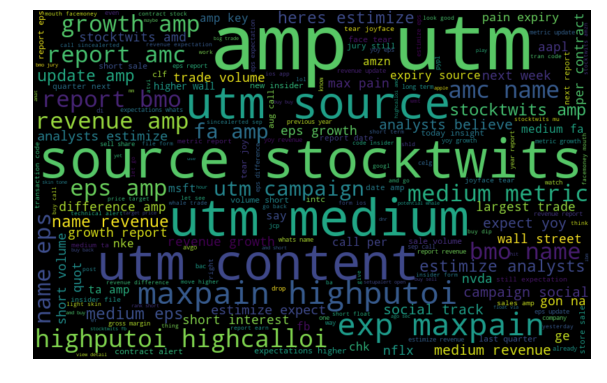

In [147]:
all_words = ' '.join([text for text in train['Processed_data']])
from wordcloud import WordCloud
wordcloud = WordCloud(width=800, height=500, random_state=42, max_font_size=110).generate(all_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

frequently used occuring words are amp,utm

### Splitting the Train & test in Json File

In [148]:
X = train['Processed_data']
Y = train['sentiment_score']

In [149]:
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer()

In [150]:
x_train_json, x_test_json, y_train_json, y_test_json = train_test_split(X, Y,test_size=0.3, random_state=123)

x_train_json = cv.fit_transform(x_train_json)
x_test_json = cv.transform(x_test_json)

In [151]:
Test_data = test_json['Processed_data']
Vectorized_test_data = cv.transform(Test_data)

### Model Building

In [152]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV,cross_val_score

In [153]:
log_reg = LogisticRegression(penalty='l2')

param_grid = {'C': [0.001, 0.01, 0.1] }
Logistic_model = GridSearchCV(log_reg, param_grid, cv=5,verbose=1, n_jobs=-1)

Logistic_model.fit(x_train_json,y_train_json)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:  4.1min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='warn',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='warn',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='warn', n_jobs=-1, param_grid={'C': [0.001, 0.01, 0.1]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=1)

In [154]:
train_json_pred = Logistic_model.predict(x_train_json)
test_json_pred = Logistic_model.predict(x_test_json)

In [155]:
print(Logistic_model.score(x_train_json, y_train_json))
print(Logistic_model.score(x_test_json, y_test_json))

0.6451674546426888
0.6363540129595175


In [156]:
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report

In [157]:
print(f1_score(y_true=y_train_json, y_pred=train_json_pred, average=None))
print(classification_report(y_true=y_train_json, y_pred=train_json_pred))

print(f1_score(y_true=y_test_json, y_pred=test_json_pred, average=None))
print(classification_report(y_true=y_test_json, y_pred=test_json_pred))

[0.58597234 0.43420963 0.75936912 0.44414329 0.62149303]
              precision    recall  f1-score   support

           0       0.67      0.52      0.59     64636
           1       0.60      0.34      0.43     84365
           2       0.66      0.89      0.76    325086
           3       0.57      0.36      0.44    145667
           4       0.65      0.59      0.62    107637

    accuracy                           0.65    727391
   macro avg       0.63      0.54      0.57    727391
weighted avg       0.64      0.65      0.62    727391

[0.57362592 0.41770563 0.75465395 0.42833076 0.60966433]
              precision    recall  f1-score   support

           0       0.65      0.51      0.57     27386
           1       0.59      0.32      0.42     36406
           2       0.65      0.89      0.75    139316
           3       0.56      0.35      0.43     62364
           4       0.64      0.58      0.61     46268

    accuracy                           0.64    311740
   macro avg     

In [158]:
test_json_Predictions = Logistic_model.predict(Vectorized_test_data)
test_json_Predictions

array([2, 4, 2, ..., 2, 2, 4], dtype=int64)

In [159]:
test_merge.sentiment_score.value_counts()

2.0    19040
3.0     2566
4.0     1387
1.0     1328
0.0      518
Name: sentiment_score, dtype: int64

In [160]:
test_json['Processed_data'] = test_json['Processed_data'].astype('category')

#### Imputing sentiment score by 2 because 2 is most frequent score

In [161]:
train_merge.fillna(2,inplace=True)

In [162]:
train_merge.isnull().sum()

Id                 0
date               0
ticker             0
SF1                0
SF2                0
SF3                0
SF4                0
SF5                0
SF6                0
SF7                0
alpha              0
sentiment_score    0
dtype: int64

In [163]:
train_merge.columns

Index(['Id', 'date', 'ticker', 'SF1', 'SF2', 'SF3', 'SF4', 'SF5', 'SF6', 'SF7',
       'alpha', 'sentiment_score'],
      dtype='object')

In [164]:
X=train_merge.drop(['Id','date','alpha'],axis=1)
y=train_merge['alpha']

In [165]:
X_train_sent,X_test_sent,y_train_sent,y_test_sent=train_test_split(X,y,test_size=0.3,random_state=42)

In [166]:
with open('test_data.json', 'r') as f:
     sntmnt_data_test = json.load(f)

In [167]:
test_sntmnt = pd.concat([pd.DataFrame(sntmnt_data_test),pd.DataFrame(list(sntmnt_data_test['records']))], axis=1).drop('records', 1)

test_sntmnt.head(3)

,stocktwit_tweet,ticker,timestamp
0,$CELG nothing to be exited about,$CELG,2018-10-25 14:26:16+00:00
1,$AMD yall exhaust your buyer on first green ca...,$AMD,2018-07-13 13:50:39+00:00
2,$AMD day traders day.,$AMD,2018-09-25 19:10:54+00:00


In [168]:
test_sntmnt['timestamp'] = test_sntmnt['timestamp'].str.split(' ').str[0]

In [169]:
test_sntmnt['ticker'] = test_sntmnt['ticker'].str.replace('$','')
test_sntmnt['ticker'] = test_sntmnt['ticker'].str.upper()

In [ ]:
test_sntmnt['sentiment_score'] = test_json_Predictions

In [ ]:
## Merging test CSV and test JSON

test_json_groupby = test_json.groupby(by=['time','ticker'])['sentiment_score'].agg(lambda x: x.value_counts().index[0]).to_frame()

test_json_merge = pd.merge(test_sntmnt test_json_groupby , how='left', left_on = ['ticker','date'],right_on=['ticker','timestamp'])

test_json_merge.head()

test_json_merge.isna().sum()

In [170]:
test_sntmnt.head(3)

,stocktwit_tweet,ticker,timestamp
0,$CELG nothing to be exited about,CELG,2018-10-25
1,$AMD yall exhaust your buyer on first green ca...,AMD,2018-07-13
2,$AMD day traders day.,AMD,2018-09-25


In [171]:
test_sntmnt['sentiment_score'] = test_json_Predictions

Decision Tree 

In [172]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_attr),
        ('cat', categorical_transformer, cat_attr)])

In [173]:
%%time
clf_dt = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', DecisionTreeClassifier())])

dt_param_grid = {'classifier__criterion': ['entropy', 'gini'], 'classifier__max_depth': [6,8,10,12], 
                 "classifier__min_samples_split": [2, 10, 20],"classifier__min_samples_leaf": [1, 5, 10]}

Wall time: 0 ns


In [174]:
dt_grid = GridSearchCV(clf_dt, param_grid=dt_param_grid, cv=5)

In [175]:
dt_grid.fit(X_train_sent,y_train_sent)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('preprocessor',
                                        ColumnTransformer(n_jobs=None,
                                                          remainder='drop',
                                                          sparse_threshold=0.3,
                                                          transformer_weights=None,
                                                          transformers=[('num',
                                                                         Pipeline(memory=None,
                                                                                  steps=[('imputer',
                                                                                          SimpleImputer(add_indicator=False,
                                                                                                        copy=True,
                    

In [176]:
dt_grid.best_params_

{'classifier__criterion': 'entropy',
 'classifier__max_depth': 12,
 'classifier__min_samples_leaf': 10,
 'classifier__min_samples_split': 20}

In [177]:
train_pred = dt_grid.predict(X_train_sent)
test_pred = dt_grid.predict(X_test_sent)

In [178]:
print(dt_grid.score(X_train_sent, y_train_sent))
print(dt_grid.score(X_test_sent, y_test_sent))

0.7360876005078291
0.6535423352258701


In [179]:
print("F1 Score:" , f1_score(y_true= y_test_sent, y_pred = test_pred,average=None))
print(accuracy_score(y_true= y_test_sent, y_pred = test_pred))

F1 Score: [0.54929577 0.81750034 0.47160069 0.53065539]
0.6535423352258701


In [180]:
print("Recall:" , recall_score(y_true= y_test_sent, y_pred = test_pred,average=None))
print("Precison:" , precision_score(y_true= y_test_sent, y_pred = test_pred,average=None))

Recall: [0.52348993 0.91937462 0.41973039 0.47992352]
Precison: [0.57777778 0.73595092 0.53809898 0.59338061]


In [182]:
new_df1 = pd.DataFrame(list(zip(test['Id'],test_sample_pred1)),columns=['Id','alpha'])
new_df1.shape

(11575, 2)

### _Some Insights from the EDA done above_

1. Most of the Sentiment Scores have values 2 in the Tweet, which indicate more of Neutral Sentiment
2. Most of the tweets are about the stocks Advanced Micro Devices followed by Micron Technology
3. General WordClouds have more of ATM parameters of Stocks Terms in the Overall Corpus

Decison tree classifer is used for precidiction without sentiment score is good so same is used for with sentiment score

### Even after adding sentiment score extracted from tweets of companies precidtion is not increased further, 
### So this  predicted  alpha value from sentiment score does not determine right investment,
### if invest from  this analysis companies may fail to return the values they may need,
### So tweets cannot determine the investment for companies ,as it a social media data so all cannot be true investors.